In [32]:
# dependenicies 
import pandas as pd
import numpy as np

#for vif
from statsmodels.stats.outliers_influence import variance_inflation_factor

# for data processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# sklearn modules for Model Selection:
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

# for model building
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import classification_report

#for viz
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

In [33]:
# Version Control
print('pandas-',pd.__version__)
print('numpy-',np.__version__)
print('seaborn-',sns.__version__)
print('xgboost-',xgb.__version__)

pandas- 1.2.3
numpy- 1.19.2
seaborn- 0.11.1
xgboost- 1.4.2


In [3]:
# Read Dataset
d_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d') # for creating date_parser

activity = pd.read_csv('activity.csv', parse_dates=['date'], date_parser = d_parser)
target = pd.read_csv('target.csv', parse_dates=['date'], date_parser = d_parser)

<ipython-input-3-69d570a162b8>:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  d_parser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d') # for creating date_parser


# Section A : Data Processing

In [4]:
# check datatype and memory info
print('activity dataset info-')
activity.info()
print('\n'+'target dataset info-')
target.info()

activity dataset info-
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904772 entries, 0 to 904771
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            904772 non-null  datetime64[ns]
 1   customer        904772 non-null  object        
 2   activity_type   904772 non-null  object        
 3   activity_count  904772 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 27.6+ MB

target dataset info-
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4356 entries, 0 to 4355
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   customer  4356 non-null   object        
 1   date      4356 non-null   datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 68.2+ KB


#### Comment: 
<br>Shows there is no null values in the datasets

In [5]:
print('The datset shows the duration is in between ', activity.date.min().date(), "to" ,activity.date.max().date())

The datset shows the duration is in between  2020-09-01 to 2021-05-23


In [6]:
# process datasets to Merge activity and target dataset
def process_data(activity,target):
    target = target.rename(columns = {'date': 'close_date'}, inplace = False) # reaname date in target datset into close_date 
    
    # create a pivot table to groupby customer with their activiyt types and accumulate (sum) activity_count with 
    # opening_date of the type 
    activity = activity.pivot_table(index=['customer','activity_type'],values=['activity_count','date'],
                      aggfunc={'activity_count': np.sum,
                               'date': min}).reset_index()
    activity = activity.rename(columns = {'date': 'opening_date'}, inplace = False)
    dataset = activity.merge(target, on='customer', how='left') # merge activity and target datset
    dataset['close_deals?'] = dataset.close_date.fillna(0).apply(lambda x: 0 if x == 0  else 1) # with value 1 indicates closing the deal
    
    
    dataset['close_date'] = pd.to_datetime(dataset['close_date'], format='%Y-%m-%d')# converting into datetime format
    
    
    # to create a new column to know how long the deals with the customeris active till the last date '2021-05-23'
    # for closed deals days_active will be the interval between the date and close_date 
    dataset['days_active_1'] = (dataset['close_date'] - dataset['opening_date']).dt.days.fillna(0).astype(int)
    dataset['days_active_0'] = (pd.to_datetime('2021-05-23') - dataset.opening_date).dt.days.astype(int)
    dataset['days_active'] = (dataset['days_active_0'] * (1-dataset['close_deals?']) - dataset['days_active_1']).abs()
    dataset = dataset.drop(['days_active_1', 'days_active_0'], axis=1)
    return dataset

In [7]:
processed = process_data(activity,target)

In [8]:
processed.head(10)

,customer,activity_type,activity_count,opening_date,close_date,close_deals?,days_active
0,0030o00002nkSmtAAE,b,1,2020-11-24,NaT,0,180
1,0030o00002nkSmuAAE,b,1,2020-12-09,NaT,0,165
2,0030o00002nkSmuAAE,j,2,2020-09-11,NaT,0,254
3,0030o00002nkSnHAAU,m,2,2021-01-08,NaT,0,135
4,0030o00002nkSnHAAU,v,9,2020-12-25,NaT,0,149
5,0030o00002nkSnIAAU,a,4,2020-09-03,NaT,0,262
6,0030o00002nkSnfAAE,h,1,2020-11-20,2020-11-25,1,5
7,0030o00002nkSnfAAE,i,2,2020-11-21,2020-11-25,1,4
8,0030o00002nkSnfAAE,l,6,2020-11-21,2020-11-25,1,4
9,0030o00002nkSnfAAE,m,6,2020-11-20,2020-11-25,1,5


In [9]:
processed.shape

(357785, 7)

In [10]:
processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 357785 entries, 0 to 357784
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   customer        357785 non-null  object        
 1   activity_type   357785 non-null  object        
 2   activity_count  357785 non-null  int64         
 3   opening_date    357785 non-null  datetime64[ns]
 4   close_date      26317 non-null   datetime64[ns]
 5   close_deals?    357785 non-null  int64         
 6   days_active     357785 non-null  int64         
dtypes: datetime64[ns](2), int64(3), object(2)
memory usage: 21.8+ MB


In [11]:
processed.describe(include='all')

<ipython-input-11-44af56d6c5ba>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  processed.describe(include='all')
<ipython-input-11-44af56d6c5ba>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  processed.describe(include='all')


,customer,activity_type,activity_count,opening_date,close_date,close_deals?,days_active
count,357785,357785,357785.000000,357785,26317,357785.000000,357785.000000
unique,139556,25,NaN,264,185,NaN,NaN
top,0032j000008mwf2AAA,x,NaN,2021-02-16 00:00:00,2021-02-24 00:00:00,NaN,NaN
freq,18,51618,NaN,5576,324,NaN,NaN
first,NaN,NaN,NaN,2020-09-01 00:00:00,2020-11-01 00:00:00,NaN,NaN
last,NaN,NaN,NaN,2021-05-22 00:00:00,2021-05-22 00:00:00,NaN,NaN
mean,NaN,NaN,2.528815,NaN,NaN,0.073555,129.196529
std,NaN,NaN,6.490083,NaN,NaN,0.261046,75.112454
min,NaN,NaN,1.000000,NaN,NaN,0.000000,0.000000
25%,NaN,NaN,1.000000,NaN,NaN,0.000000,69.000000


#### This concludes the following decision-
<br> 1. occurances of 265 days is found from the dataset with maximum frequency 5576 (with similar activity_type) in between 2020-09-01 to 2021-05-23
<br> 2. shows total of 1,39,556 unique customer id with 25 different activity_type where 'x' is the highest (51,618 times). 
<br> 3. we have 1,02,285 records with  4356 unique customer id who closes the deals within the date frame. 

In [12]:
# Check target variable distribution:
processed['close_deals?'].value_counts()

0    331468
1     26317
Name: close_deals?, dtype: int64

### Comments-
As you can see below, the processed dataset is imbalanced with a high proportion of active customers compared to their churned(closed deals) counterparts.

In [13]:
#Convert activity_type (categorical variables) into dummy variable:
activity_dummies = pd.get_dummies(processed.activity_type,prefix='activity_type')

# now selecting varibale that might play significant role for future use
final = pd.concat([activity_dummies, processed[['activity_count','days_active','close_deals?','customer']]], axis = 1)
final.head()

,activity_type_a,activity_type_b,activity_type_c,activity_type_d,activity_type_e,activity_type_f,activity_type_g,activity_type_h,activity_type_i,activity_type_j,...,activity_type_t,activity_type_u,activity_type_v,activity_type_w,activity_type_x,activity_type_y,activity_count,days_active,close_deals?,customer
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,180,0,0030o00002nkSmtAAE
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,165,0,0030o00002nkSmuAAE
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,2,254,0,0030o00002nkSmuAAE
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,2,135,0,0030o00002nkSnHAAU
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,9,149,0,0030o00002nkSnHAAU


# Section B: Data Evaluation

### Exploratory Data Analysis: 

In [14]:
x1 = final[['activity_count','days_active']]
y = final['close_deals?']

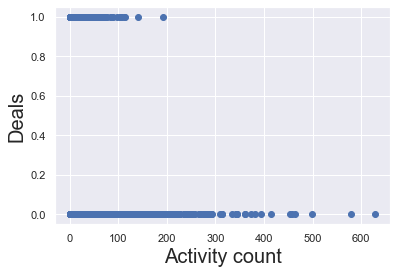

In [15]:
# Create a scatter plot of x1 (activity_count) and y (close_deals?)
plt.scatter(x1['activity_count'],y,color = 'C0')
# Don't forget to label your axes!
plt.xlabel('Activity count', fontsize = 20)
plt.ylabel("Deals", fontsize = 20)
plt.show()

### Comment:
<br> Customers with less activity count (arround 100 times) have tendency to close the deal. 

[Text(0.5, 0, 'Number of Active Days '),
 Text(0, 0.5, 'counts'),
 Text(0.5, 1.0, 'Days effect on Closed Deals')]

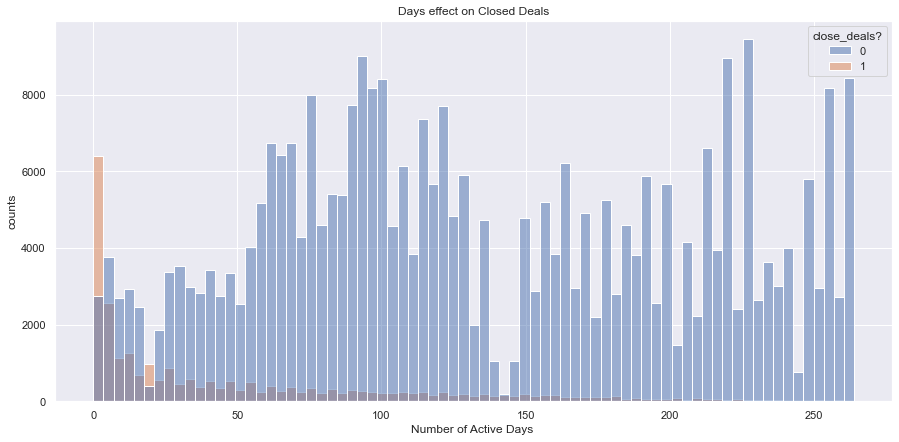

In [16]:
# check if there are any effect of days_active on close deals or not
fig, ax1 = plt.subplots(figsize=(15, 7))
ax1 = sns.histplot(data=final, x="days_active",hue='close_deals?')
ax1.set(xlabel='Number of Active Days ', ylabel='counts', title='Days effect on Closed Deals')

#### Comment:
<br> Which shows clear evidence that as the number of active days with a customer increase with the company, customer are less likely to closing the deals.

[Text(0.5, 0, 'Activity Type Name'),
 Text(0, 0.5, 'counts'),
 Text(0.5, 1.0, 'Counts of different activity_type')]

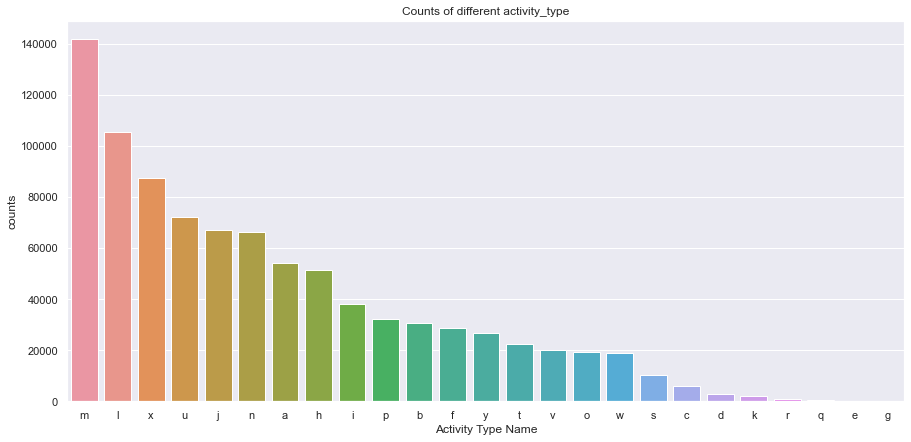

In [17]:
# check occurances of different activity types
fig, ax1 = plt.subplots(figsize=(15, 7))
activity_type_check = activity.activity_type.value_counts().to_frame().reset_index()
ax = sns.barplot(x="index", y="activity_type", data=activity_type_check)
ax1.set(xlabel='Activity Type Name', ylabel='counts', title='Counts of different activity_type')

### Analyze the churn (close deals) rate by categorical variables (customer, activity_type)

<ipython-input-18-4612faa62d22>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_rate ["churn_label"] = pd.Series(np.where((churn_rate["close_deals?"] == 0), "No", "Yes"))


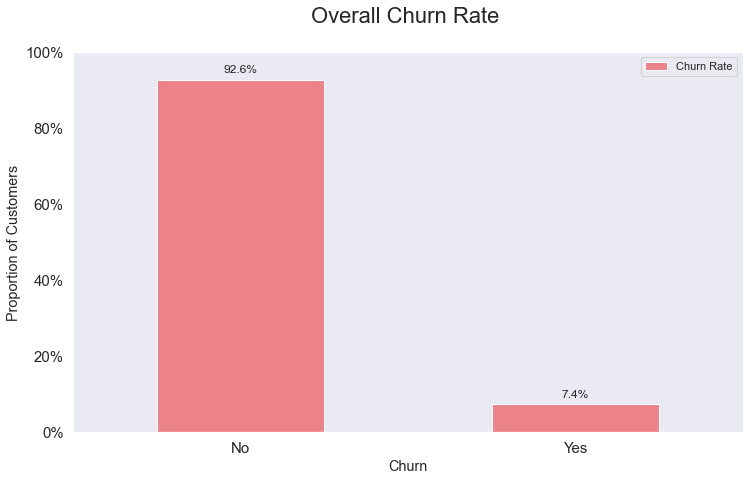

In [18]:
#Churn Rate by customer deals:
churn_rate = final[["close_deals?", "customer"]]
churn_rate ["churn_label"] = pd.Series(np.where((churn_rate["close_deals?"] == 0), "No", "Yes"))
sectors = churn_rate .groupby ("churn_label")
churn_rate = pd.DataFrame(sectors["customer"].count())
churn_rate ["Churn Rate"] = (churn_rate ["customer"]/ sum(churn_rate ["customer"]) )*100

ax =  churn_rate[["Churn Rate"]].plot.bar(title = 'Overall Churn Rate',legend =True, table = False,grid = False,  subplots = False, 
figsize =(12, 7), color = '#ec838a', fontsize = 15, stacked=False, ylim =(0,100))
plt.ylabel('Proportion of Customers',horizontalalignment="center",
fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Churn',horizontalalignment="center",fontstyle = "normal", fontsize = "large", fontfamily = "sans-serif")
plt.title('Overall Churn Rate \n',horizontalalignment="center", 
fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")
# plt.legend(loc='top right', fontsize = "medium")
plt.xticks(rotation=0, horizontalalignment="center")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
x_labels = np.array(churn_rate[["customer"]])
def add_value_labels(ax, spacing=5):   
    for rect in ax.patches:     
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2       
        space = spacing
        va = 'bottom'        
        if y_value < 0:           
            space *= -1          
            va = 'top'
        label = "{:.1f}%".format(y_value)    
 
        ax.annotate(label,
                    (x_value, y_value),         
                     xytext=(0, space),
                     textcoords="offset points", 
                     ha='center',va=va)
add_value_labels(ax)
ax.autoscale(enable=False, axis='both', tight=False)

In [19]:
# preparing datasets for churn against activity_type
targets = target.rename(columns = {'date': 'close_date'}, inplace = False)
datasets = activity.merge(targets, on='customer', how='left')
datasets['close_deals?'] = datasets.close_date.fillna(0).apply(lambda x: 0 if x == 0  else 1)
datasets.head()

,date,customer,activity_type,activity_count,close_date,close_deals?
0,2021-01-20,0032j000002jRYxAAM,a,1,NaT,0
1,2021-05-11,0032j00000FZcIvAAL,a,1,NaT,0
2,2020-12-09,0032j000002gKM8AAM,a,1,NaT,0
3,2021-03-30,0032j000001UX7cAAG,a,1,NaT,0
4,2020-10-19,0032j000004etUWAAY,a,1,2021-04-07,1


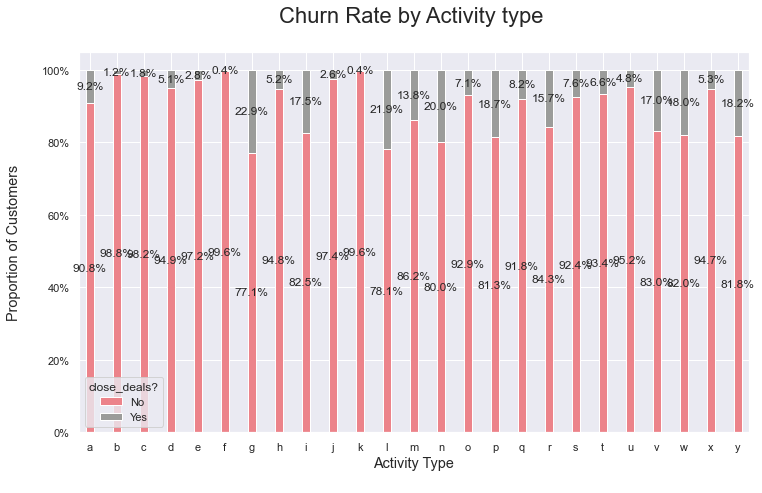

In [20]:
# Churn Rate by Activity Type:
activity_type_churn = datasets.groupby(['activity_type','close_deals?']).size().unstack()
activity_type_churn.rename(columns={0:'No', 1:'Yes'}, inplace=True)

colors  = ['#ec838a','#9b9c9a']
ax = (activity_type_churn.T*100.0 / activity_type_churn.T.sum()).T.plot(kind='bar',width = 0.3,stacked = True,rot = 0,figsize = (12,7),color = colors)

plt.ylabel('Proportion of Customers\n',
            horizontalalignment="center",fontstyle = "normal", 
            fontsize = "large", fontfamily = "sans-serif")
plt.xlabel('Activity Type\n',horizontalalignment="center",
            fontstyle = "normal", fontsize = "large", 
            fontfamily = "sans-serif")
plt.title('Churn Rate by Activity type \n',
            horizontalalignment="center", fontstyle = "normal", 
            fontsize = "22", fontfamily = "sans-serif")
plt.yticks(rotation=0, horizontalalignment="right")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    ax.text(x+width/2, 
            y+height/2, 
            '{:.1f}%'.format(height), 
            horizontalalignment='center', 
            verticalalignment='center')
ax.autoscale(enable=False, axis='both', tight=False)

In [66]:
# activity_type vs contribution
results = activity_type_churn.T*100.0 / activity_type_churn.T.sum()
results.T.rename(columns={'close_deals?':'contribution'})

close_deals?,No,Yes
activity_type,,
a,90.789449,9.210551
b,98.768594,1.231406
c,98.233851,1.766149
d,94.941349,5.058651
e,97.183099,2.816901
f,99.593806,0.406194
g,77.083333,22.916667
h,94.806737,5.193263
i,82.513532,17.486468


In [70]:
results.T.to_csv('results.csv') #save file

### detemine the feature & target variable and their correlations:-

In [21]:
x = final.iloc[:,:-2]
y = final[['close_deals?']]

Text(0.5, 1.0, 'Correlation with Churn Rate \n')

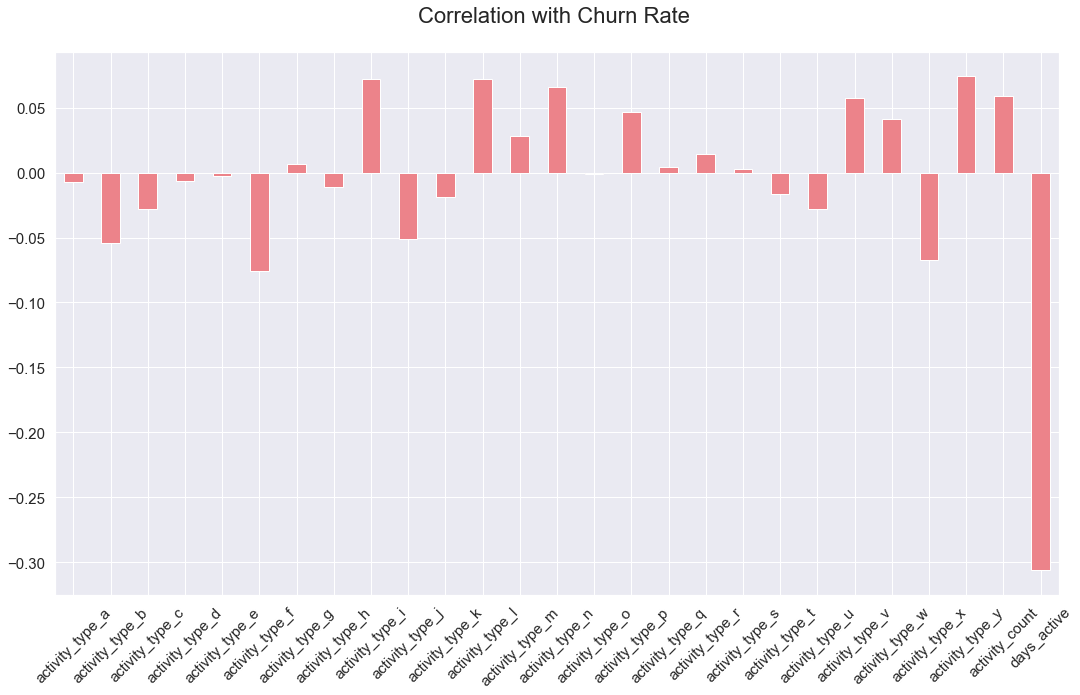

In [22]:
# correlation between feature and target variable - 
correlations = x.corrwith(y['close_deals?'])
correlations = correlations[correlations!=1]
correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 15, 
        color = '#ec838a',
        rot = 45, grid = True)
plt.title('Correlation with Churn Rate \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

<AxesSubplot:>

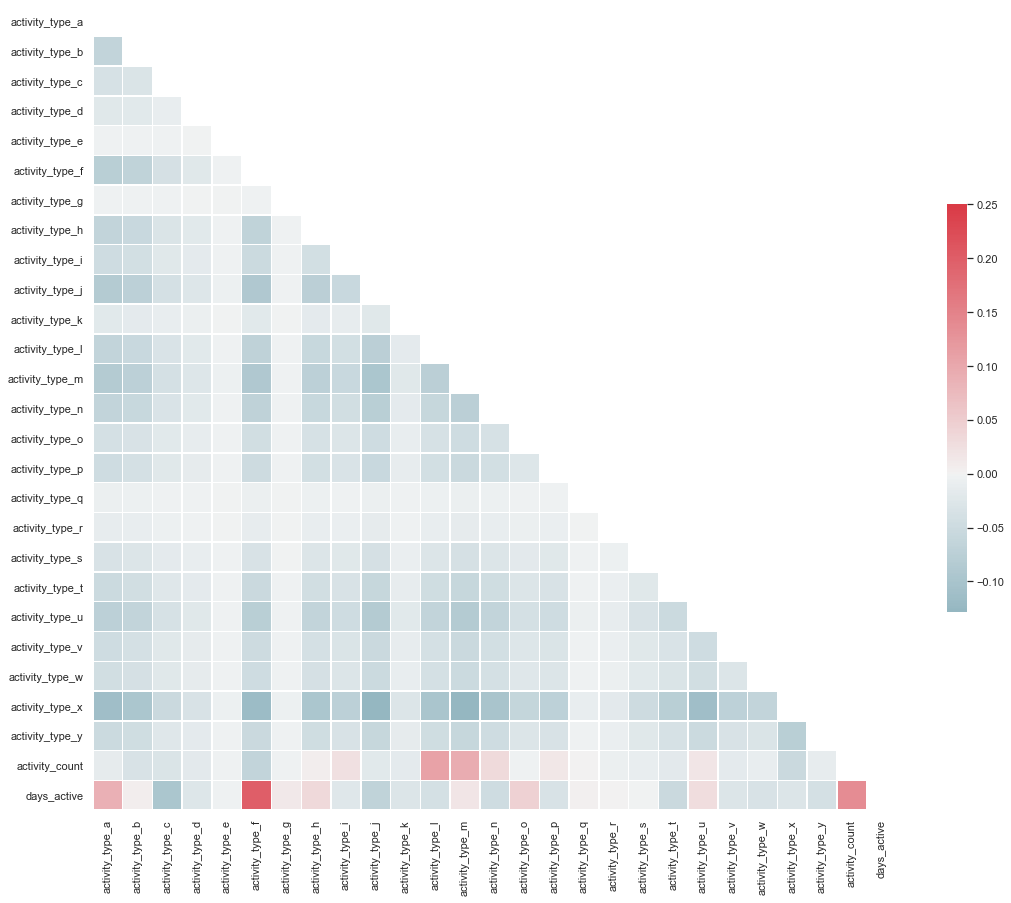

In [23]:
# correlation between feature variables -
sns.set(style="white")
corr = x.corr()
#Generate a mask for the upper triangle:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#Set up the matplotlib figure and a diverging colormap:
f, ax = plt.subplots(figsize=(18, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#Draw the heatmap with the mask and correct aspect ratio:
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.25, center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Check Multicollinearity using VIF

In [24]:
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) 
    for i in range(X.shape[1])]
    return(vif)

calc_vif(x)

,variables,VIF
0,activity_type_a,1.309308
1,activity_type_b,1.173021
2,activity_type_c,1.017430
3,activity_type_d,1.014465
4,activity_type_e,1.000449
5,activity_type_f,1.478148
6,activity_type_g,1.001165
7,activity_type_h,1.199762
8,activity_type_i,1.087018
9,activity_type_j,1.220018


### comment:-
<br> There is no multicolinerarity between the feature variables.

### Generate training and test datasets:

In [25]:
# Let’s decouple the master dataset into training and test set with an 90%-10% ratio.
X_train, X_test, y_train, y_test = train_test_split(x, y,stratify=y, test_size = 0.1,random_state = 0) #to resolve any class imbalance - use stratify parameter.

# print shape of the train test model
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (322006, 27)
Number transactions y_train dataset:  (322006, 1)
Number transactions X_test dataset:  (35779, 27)
Number transactions y_test dataset:  (35779, 1)


### Conduct Feature Scaling:

In [26]:
sc_X = StandardScaler()
X_train2 = pd.DataFrame(sc_X.fit_transform(X_train))
X_train2.columns = X_train.columns.values
X_train2.index = X_train.index.values
X_train = X_train2
X_test2 = pd.DataFrame(sc_X.transform(X_test))
X_test2.columns = X_test.columns.values
X_test2.index = X_test.index.values
X_test = X_test2

# Section C: Model Selection

In [27]:
#building the model & printing the score
xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.08, objective= 'binary:logistic',n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(xgb_model.score(X_test[X_train.columns], y_test)))

C:\Users\NybSys\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\NybSys\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[23:07:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy of XGB classifier on training set: 0.95
Accuracy of XGB classifier on test set: 0.96


### comment:-
<br> By using this simple model, we have achieved 96% accuracy:

In [28]:
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98     33147
           1       0.85      0.48      0.62      2632

    accuracy                           0.96     35779
   macro avg       0.91      0.74      0.80     35779
weighted avg       0.95      0.96      0.95     35779



### Comment:-
<br> 1. We can interpret the report above as if our model tells us, 100 customers will churn, 85 of it will churn (0.85 precision). 
<br> 2. And actually, there are around 30,515 customers who will churn (0.48recall). 
<br> 3. Especially recall is the main problem here, and we can improve our model’s overall performance by:
   <br> --     Adding more data 
   <br> --     Adding more features
   <br> --     More feature engineering
   <br> --     Trying other models
   <br> --     Hyper-parameter tuning

### which were the most important ones?

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

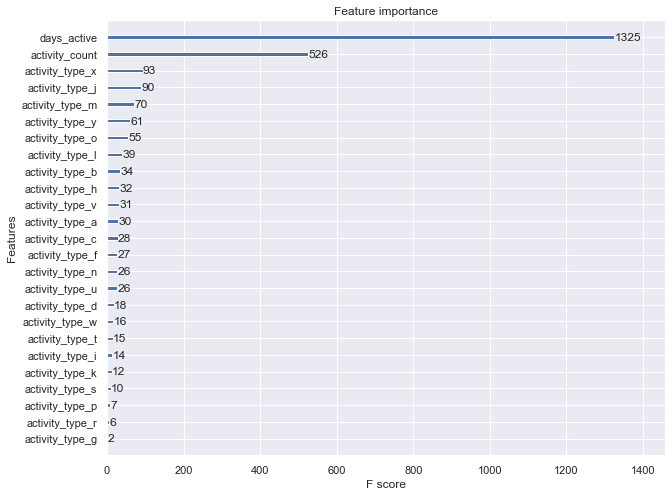

In [29]:
sns.set()
fig, ax = plt.subplots(figsize=(10,8))
plot_importance(xgb_model, ax=ax)

### predict the probability of closing deals with each customer

In [39]:
final['probility'] = xgb_model.predict_proba(final[X_train.columns])[:,1]
final[['customer', 'probility']].drop_duplicates(subset=None, keep='first', inplace=False) #removing duplicates

,customer,probility
0,0030o00002nkSmtAAE,0.003377
1,0030o00002nkSmuAAE,0.003377
2,0030o00002nkSmuAAE,0.003544
3,0030o00002nkSnHAAU,0.003544
4,0030o00002nkSnHAAU,0.003664
...,...,...
357778,0032j00000GjPtaAAF,0.227787
357779,0032j00000GjPtaAAF,0.337805
357780,0032j00000GjPtaAAF,0.328380
357781,0032j00000GjPtaAAF,0.003544
